# 3.2.1 Deep analysis of AVERANGE_ROW_COUNT 

This dashboard answers the following questions:
- [X] How to retrieve components from report logs
- [X] Which "Lightning component"  are fetching an amount of data of more than the averge?
- [X] Which columns are present on those Lightning component reports?

In [1]:
import os
import pandas as pd

In [2]:
os.listdir("./datasets/")

['active_reports_180.csv',
 'Page_View_error_log.csv',
 'active_reports_that_have_been_running_the_longest_in_period.csv',
 'Page_View_by_USER_ID_DERIVED-SESSION_KEY.csv',
 'active_reports_that_have_been_running_the_longest.csv',
 'active_reports.csv']

### Loading reports

In [3]:
reports = pd.read_csv("./datasets/active_reports.csv",low_memory=False)

In [4]:
reports.shape

(7101, 50)

Let's sorted table values by `AVERAGE_ROW_SIZE`(ARS) column to start the filters

In [5]:
sorted_by_ARS = reports.sort_values(['AVERAGE_ROW_SIZE', 'ROW_COUNT'], ascending=False)
sorted_by_ARS[['AVERAGE_ROW_SIZE', 'ROW_COUNT']]

,AVERAGE_ROW_SIZE,ROW_COUNT
6605,2982.0,8.0
6606,2982.0,8.0
6607,2982.0,8.0
6608,2982.0,8.0
6609,2982.0,8.0
...,...,...
5792,266.0,1.0
5817,266.0,1.0
5894,266.0,1.0
6538,114.0,104671.0


Let's remove unsed columns

In [6]:
sorted_by_ARS = sorted_by_ARS.drop(columns=['CreatedById',
 'CreatedDate',
 'Description',
 'DeveloperName',
 'FolderName',
 'Format',
 'Id',
 'IsDeleted',
 'LastModifiedById',
 'LastModifiedDate',
 'LastReferencedDate',
 'LastViewedDate',
 'OwnerId',
 'ReportTypeApiName',
 'SystemModstamp',
 'TIMESTAMP',
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'URI',
 'USER_TYPE',
 'REQUEST_STATUS',
 'DB_TOTAL_TIME',
 'ENTITY_NAME',
 'DISPLAY_TYPE',
 'RENDERING_TYPE',
 'REPORT_ID',
 'NUMBER_EXCEPTION_FILTERS',
 'NUMBER_COLUMNS',
 'SORT',
 'DB_BLOCKS',
 'DB_CPU_TIME',
 'NUMBER_BUCKETS',
 'TIMESTAMP_DERIVED',
 'USER_ID_DERIVED',
 'CLIENT_IP',
 'URI_ID_DERIVED',
 'IsActive',
 'NamespacePrefix'])

Let's remove all reports that don't have an origin associated with lighitning according [documatation](https://developer.salesforce.com/docs/atlas.en-us.object_reference.meta/object_reference/sforce_api_objects_eventlogfile_report.ht)

In [7]:
sorted_by_ARS = sorted_by_ARS[(sorted_by_ARS['ORIGIN'] == 'ReportRunFromLightning')]

Let's try remove row's with 0 and missing values in `AVERAGE_ROW_SIZE`

In [8]:
sorted_by_ARS.drop(sorted_by_ARS[(sorted_by_ARS["AVERAGE_ROW_SIZE"] == 0)].index, inplace=True)
sorted_by_ARS.dropna(subset='AVERAGE_ROW_SIZE')
sorted_by_ARS.shape

(7101, 11)

Now, let's define an average based on the number of bytes per line following a [documatation](https://developer.salesforce.com/docs/atlas.en-us.object_reference.meta/object_reference/sforce_api_objects_eventlogfile_report.ht)
  > This average will be defined from a new column that calculates the product of each value of `AVERAGE_ROW_SIZE` multiplied by `ROW_COUNT`


In [73]:
list(sorted_by_ARS.columns)

['LastRunDate',
 'Name',
 'EVENT_TYPE',
 'RUN_TIME',
 'CPU_TIME',
 'SESSION_KEY',
 'LOGIN_KEY',
 'ROW_COUNT',
 'AVERAGE_ROW_SIZE',
 'REPORT_ID_DERIVED',
 'ORIGIN',
 'AVG_BYTES_PER_REPORT']

In [9]:
sorted_by_ARS['AVG_BYTES_PER_REPORT'] = sorted_by_ARS.AVERAGE_ROW_SIZE * sorted_by_ARS.ROW_COUNT
sorted_by_ARS[['AVERAGE_ROW_SIZE','ROW_COUNT','AVG_BYTES_PER_REPORT']].head()

,AVERAGE_ROW_SIZE,ROW_COUNT,AVG_BYTES_PER_REPORT
6605,2982.0,8.0,23856.0
6606,2982.0,8.0,23856.0
6607,2982.0,8.0,23856.0
6608,2982.0,8.0,23856.0
6609,2982.0,8.0,23856.0


Now let's define the average of the column values

In [10]:
trashold_bytes_per_report = sorted_by_ARS.AVG_BYTES_PER_REPORT.mean()
trashold_bytes_per_report

1795724.1294183917

We will store all reports considered fraudulent in a single data frame

In [11]:
fradulent_reports = sorted_by_ARS[(sorted_by_ARS.AVG_BYTES_PER_REPORT >= trashold_bytes_per_report)]
fradulent_reports.head()

,LastRunDate,Name,EVENT_TYPE,RUN_TIME,CPU_TIME,SESSION_KEY,LOGIN_KEY,ROW_COUNT,AVERAGE_ROW_SIZE,REPORT_ID_DERIVED,ORIGIN,AVG_BYTES_PER_REPORT
6556,2022-06-20T01:54:25.000,Open Tasks (Blue Steel),Report,17302,3377,9k/UMOlWlwcms+Gm,egDgzt4/gZq+i2SM,74459.0,2078.0,00O0b000004AnheEAC,ReportRunFromLightning,1.547258e+08
6557,2022-06-20T01:54:25.000,Open Tasks (Blue Steel),Report,24796,7092,9k/UMOlWlwcms+Gm,egDgzt4/gZq+i2SM,204491.0,2067.0,00O0b000004AnheEAC,ReportRunFromLightning,4.226829e+08
6501,2022-06-20T01:54:25.000,Open Tasks (Blue Steel),Report,280250,125209,9k/UMOlWlwcms+Gm,egDgzt4/gZq+i2SM,3790169.0,1942.0,00O0b000004AnheEAC,ReportRunFromLightning,7.360508e+09
6549,2022-06-20T01:54:25.000,Open Tasks (Blue Steel),Report,10229,618,9k/UMOlWlwcms+Gm,egDgzt4/gZq+i2SM,2416.0,865.0,00O0b000004AnheEAC,ReportRunFromLightning,2.089840e+06
6559,2022-06-20T01:54:25.000,Open Tasks (Blue Steel),Report,11128,649,9k/UMOlWlwcms+Gm,egDgzt4/gZq+i2SM,2416.0,865.0,00O0b000004AnheEAC,ReportRunFromLightning,2.089840e+06


Let's define functions for filtering mean and median of values.

In [12]:
def filter_ars_by_mean(ars_value):
    return ars_value > trashold_bytes_per_report 

### Until the moment
So far, we have been able to:
- [x] Clear data to apply filtering
- [x] Keep only as apparent to relationships

And let's start from:

- [ ] Apply filtering
- [ ] Make plot's for each one of them



Importing matplotlib.pyplot for making the plots

In [13]:
import matplotlib.pyplot as plt

Applying the filters for mean and median

In [14]:
comparing_fraudulent_reports = sorted_by_ARS.AVG_BYTES_PER_REPORT.apply(filter_ars_by_mean)
comparing_fraudulent_reports

6605    False
6606    False
6607    False
6608    False
6609    False
        ...  
5792    False
5817    False
5894    False
6538     True
6539     True
Name: AVG_BYTES_PER_REPORT, Length: 7101, dtype: bool

Generating the plot including fraudulent reports 

We will remove fraudulent reports by applying a threshold of values ​​that are below average as fraudulent values ​​following the documentation

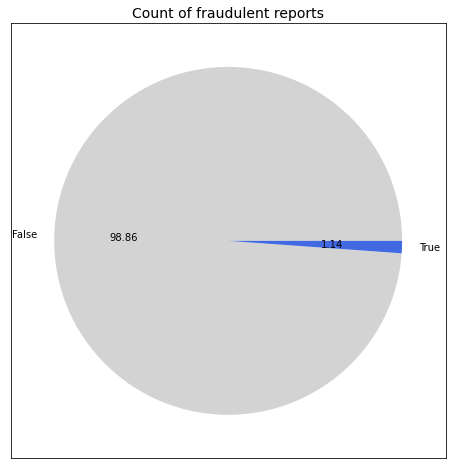

False    7020
True       81
Name: AVG_BYTES_PER_REPORT, dtype: int64

In [72]:
# Making a plot
plt.figure(figsize=(8, 8))
plt.pie(comparing_fraudulent_reports.value_counts(), labels=comparing_fraudulent_reports.unique(), autopct="%.2f", colors=["lightgrey", "royalblue"])
plt.title('Count of fraudulent reports', fontsize=14)
plt.box(on=None)
plt.show()
comparing_fraudulent_reports.value_counts()

In [87]:
# active reports with bytes per line
act_reports_w_bytes_per_line = sorted_by_ARS[['Name', 'AVG_BYTES_PER_REPORT']]
act_reports_w_bytes_per_line = reports.sort_values('AVG_BYTES_PER_REPORT', ascending=False)
act_reports_w_bytes_per_line

,Name,AVG_BYTES_PER_REPORT
6501,Open Tasks (Blue Steel),7.360508e+09
6557,Open Tasks (Blue Steel),4.226829e+08
6556,Open Tasks (Blue Steel),1.547258e+08
6458,Open Tasks (Blue Steel),8.400469e+07
6461,Open Tasks (Blue Steel),8.400148e+07
...,...,...
5770,Agent Timesheet_Omni,2.660000e+02
5791,Agent Timesheet_Omni,2.660000e+02
5792,Agent Timesheet_Omni,2.660000e+02
5817,Agent Timesheet_Omni,2.660000e+02


### After seeing the values that are above the mean, we can conclude that

- We were able to identify fraudulent active reports, they make up 1.14% within active reports

> Now we will link these fraudulent reports with the Page View components

## Loading ELF tables


>Now we will make the relationship with the PageView table, so we can analyze which Lightning-type  component pages acessed are fraudlents

In [16]:
os.listdir("data/Salesforce/ELF/LightningPageView")

['2022-06-04_LightningPageView.csv',
 '2022-06-05_LightningPageView.csv',
 '2022-06-20_LightningPageView.csv']

In [17]:
page_view = pd.read_csv("data/Salesforce/ELF/LightningPageView/2022-06-04_LightningPageView.csv", low_memory=False)
page_view.shape

(792349, 50)

In [18]:
list(page_view.columns)

['EVENT_TYPE',
 'TIMESTAMP',
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'CLIENT_ID',
 'SESSION_KEY',
 'LOGIN_KEY',
 'USER_TYPE',
 'APP_NAME',
 'DEVICE_PLATFORM',
 'SDK_APP_VERSION',
 'OS_NAME',
 'OS_VERSION',
 'USER_AGENT',
 'BROWSER_NAME',
 'BROWSER_VERSION',
 'SDK_VERSION',
 'DEVICE_MODEL',
 'DEVICE_ID',
 'SDK_APP_TYPE',
 'CLIENT_GEO',
 'CONNECTION_TYPE',
 'UI_EVENT_ID',
 'UI_EVENT_SOURCE',
 'UI_EVENT_TIMESTAMP',
 'PAGE_START_TIME',
 'DURATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION_REASON',
 'EFFECTIVE_PAGE_TIME_DEVIATION_ERROR_TYPE',
 'EFFECTIVE_PAGE_TIME',
 'DEVICE_SESSION_ID',
 'UI_EVENT_SEQUENCE_NUM',
 'PAGE_ENTITY_ID',
 'PAGE_ENTITY_TYPE',
 'PAGE_CONTEXT',
 'PAGE_URL',
 'PAGE_APP_NAME',
 'PREVPAGE_ENTITY_ID',
 'PREVPAGE_ENTITY_TYPE',
 'PREVPAGE_CONTEXT',
 'PREVPAGE_URL',
 'PREVPAGE_APP_NAME',
 'TARGET_UI_ELEMENT',
 'PARENT_UI_ELEMENT',
 'GRANDPARENT_UI_ELEMENT',
 'TIMESTAMP_DERIVED',
 'USER_ID_DERIVED',
 'CLIENT_IP']

Let's find the table that is related to the reports

Let's relate these tables in a single data frame

In [19]:
page_view.PAGE_CONTEXT.unique()

array(['home:landing', 'one:twoColumnLayout',
       'forceSearch:searchPageDesktop', 'omni:supervisorPanel',
       'force:objectHomeDesktop', 'force:relatedListDesktop',
       'one:recordHomeFlexipage2Wrapper', 'one:consoleObjectHome',
       'one:recordHomeFlexipage', 'one:recordActionWrapper',
       'one:auraContainer', 'Prechat', 'Chat', 'unknown',
       'reports:reportBase', 'forceKnowledge:articleRedirect',
       'onesetup:baseHomePage', 'sfa:analyticsHome', 'one:alohaPage',
       'forceSearch:search', 'forceChatter:desktopChatter', 'Waiting',
       'forceSearch:searchPage',
       'runtime_platform_actions:quickActionWrapper',
       'desktopDashboards:dashboard', 'undefined',
       'runtime_sales_activities:taskBorderLayout',
       'usage_app:lightningUsageSwitcher', 'onesetup:setupAlohaPage',
       'one:utilityBarPopoutWrapper', 'e.forceContent:openPreview',
       'Postchat', 'markup://force:routingRetryPanel',
       'forceChatter:feedElementFullView', 'force:relat

Let's remove unsed columns

In [20]:
page_view = page_view.drop(columns=['EVENT_TYPE',
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'CLIENT_ID',
 'LOGIN_KEY',
 'USER_TYPE',
 'APP_NAME',
 'DEVICE_PLATFORM',
 'SDK_APP_VERSION',
 'OS_NAME',
 'OS_VERSION',
 'USER_AGENT',
 'BROWSER_NAME',
 'BROWSER_VERSION',
 'SDK_VERSION',
 'DEVICE_MODEL',
 'DEVICE_ID',
 'SDK_APP_TYPE',
 'CLIENT_GEO',
 'CONNECTION_TYPE',
 'UI_EVENT_ID',
 'UI_EVENT_SOURCE',
 'UI_EVENT_TIMESTAMP',
 'PAGE_START_TIME',
 'DURATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION_REASON',
 'EFFECTIVE_PAGE_TIME_DEVIATION_ERROR_TYPE',
 'EFFECTIVE_PAGE_TIME',
 'DEVICE_SESSION_ID',
 'UI_EVENT_SEQUENCE_NUM',
 'PAGE_ENTITY_ID',
 'PAGE_ENTITY_TYPE',
 'PAGE_APP_NAME',
 'PREVPAGE_ENTITY_ID',
 'PREVPAGE_ENTITY_TYPE',
 'PREVPAGE_APP_NAME',
 'TARGET_UI_ELEMENT',
 'PARENT_UI_ELEMENT',
 'GRANDPARENT_UI_ELEMENT',
 'CLIENT_IP'])

Function to extract component id inside page view

In [21]:
run_report_api_resource = "/lightning/r/"

def get_report_info_from_endpoint(page_url):
    if page_url.startswith(run_report_api_resource):
        uri = page_url.split(run_report_api_resource)
        if len(uri) >= 2:
            report_type, report_id_derived = uri[1].split("/")[:2]
            return report_type, report_id_derived

In [22]:
page_view.dropna(subset='PAGE_URL', inplace=True)

In [23]:
page_view['REPORT_INFO_DERIVED'] = page_view.PAGE_URL.apply(get_report_info_from_endpoint)

In [24]:
page_view.dropna(subset=['REPORT_INFO_DERIVED'], inplace=True)

In [25]:
page_view['REPORT_TYPE_DERIVED'] = page_view.REPORT_INFO_DERIVED.str[0]
page_view['REPORT_ID_DERIVED'] = page_view.REPORT_INFO_DERIVED.str[1]

In [26]:
page_view.REPORT_INFO_DERIVED.value_counts()

(Report, 00O0b000004kTazEAE)          5561
(Report, 00O0b000006iNwdEAE)          5502
(Report, 00O2R000004AmwmUAC)           935
(Report, 00O0b000005yLBGEA2)           860
(Report, 00O2R000003JCXaUAO)           779
                                      ... 
(WorkOrder, 0WO6P00000268UbWAI)          1
(Task, 00T6P00000I98X0UAJ)               1
(EmailMessage, 02s6P000009Yhw9QAC)       1
(Contact, 0036P000003s5GoQAI)            1
(Case, 5006P000005WVwMQAW)               1
Name: REPORT_INFO_DERIVED, Length: 129887, dtype: int64

In [27]:
page_view.drop(columns='REPORT_INFO_DERIVED')

,TIMESTAMP,SESSION_KEY,PAGE_CONTEXT,PAGE_URL,PREVPAGE_CONTEXT,PREVPAGE_URL,TIMESTAMP_DERIVED,USER_ID_DERIVED,REPORT_TYPE_DERIVED,REPORT_ID_DERIVED
18,2.022060e+13,Od9HyGqKIPjZETCy,force:relatedListDesktop,/lightning/r/a2U2R000002QEcEUAW/related/Attach...,undefined,NaN,2022-06-04T05:01:56.987Z,0050b000004KRJAAA4,a2U2R000002QEcEUAW,related
19,2.022060e+13,TfcSfhplGPDC53RN,one:recordHomeFlexipage2Wrapper,/lightning/r/Call_Transcript__c/a7Z6P0000072CX...,undefined,NaN,2022-06-04T05:01:57.559Z,0052R000009nJ1cQAE,Call_Transcript__c,a7Z6P0000072CXbUAM
20,2.022060e+13,4sBj1cTnLGwiGV9d,one:recordHomeFlexipage2Wrapper,/lightning/r/Call_Transcript__c/a7Z6P000007ILQ...,undefined,NaN,2022-06-04T05:01:57.790Z,0050b000004KCexAAG,Call_Transcript__c,a7Z6P000007ILQ5UAO
21,2.022060e+13,Jaf4hE6p30VE9J2k,one:recordHomeFlexipage2Wrapper,/lightning/r/Call_Transcript__c/a7Z6P000006ov4...,undefined,NaN,2022-06-04T05:01:57.849Z,0050b000004KCBBAA4,Call_Transcript__c,a7Z6P000006ov4sUAA
23,2.022060e+13,7v1qZzyf0WtSNvoO,one:recordHomeFlexipage2Wrapper,/lightning/r/Call_Transcript__c/a7Z6P000007bMQ...,undefined,NaN,2022-06-04T05:01:58.281Z,0050b000004KDwkAAG,Call_Transcript__c,a7Z6P000007bMQ3UAM
...,...,...,...,...,...,...,...,...,...,...
792343,2.022060e+13,B1kctdh6zWN/vLOC,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P000004rfQ0QAI/view,forceSearch:searchPageDesktop,/one/one.app#eyJjb21wb25lbnREZWYiOiJmb3JjZVNlY...,2022-06-04T23:59:59.365Z,0052R00000AOeTlQAL,Case,5006P000004rfQ0QAI
792345,2.022060e+13,4wa9sqcN+q2hH9jh,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P0000055POPQA2/view,force:objectHomeDesktop,/lightning/o/Case/list?filterName=00B2R0000054...,2022-06-04T23:59:59.487Z,0052R000008E6tpQAC,Case,5006P0000055POPQA2
792346,2.022060e+13,N94Hizl0X7a5KdYn,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P000005Ptu6QAC/view?ws=%...,one:recordHomeFlexipage2Wrapper,/lightning/r/Asset/02i6P0000066ee2QAA/view?ws=...,2022-06-04T23:59:59.758Z,0052R00000ASPZYQA5,Case,5006P000005Ptu6QAC
792347,2.022060e+13,KyrX4soD28ulvRqi,one:recordHomeFlexipage2Wrapper,/lightning/r/Call_Transcript__c/a7Z6P000007IMy...,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P000005WV2JQAW/view?ws=%...,2022-06-04T23:59:59.772Z,0056P000000DgnyQAC,Call_Transcript__c,a7Z6P000007IMyMUAW


Merging tables

In [28]:
valid_page_view_reports = pd.merge(
left=fradulent_reports,
right=page_view,
on='REPORT_ID_DERIVED')

In [29]:
valid_page_view_reports.drop(columns=[
 'EVENT_TYPE',
 'RUN_TIME',
 'CPU_TIME',
 'SESSION_KEY_x',
 'LOGIN_KEY',
 'TIMESTAMP',
 'SESSION_KEY_y'], inplace=True)

In [30]:
valid_page_view_reports.AVG_BYTES_PER_REPORT

0       154725802.0
1       154725802.0
2       154725802.0
3       154725802.0
4       154725802.0
           ...     
4952      4869105.0
4953      4869105.0
4954      4869105.0
4955      4869105.0
4956      4869105.0
Name: AVG_BYTES_PER_REPORT, Length: 4957, dtype: float64

Make a trashold for page view

In [31]:
trashold_bytes_per_page_view = valid_page_view_reports.AVG_BYTES_PER_REPORT.mean()
trashold_bytes_per_page_view

171497733.24974784

### Now let's follow these steps:

- Create a function to filter above average values, finding fraudulent components

- Generate a visualization for each applied filter

Applying filter

In [32]:
def filter_ars_by_mean_page_view(ars_value):
    return ars_value >= trashold_bytes_per_page_view

In [40]:
fraudulent_reports_page_view = valid_page_view_reports.AVG_BYTES_PER_REPORT.apply(filter_ars_by_mean_page_view)
fraudulent_reports_page_view

0       False
1       False
2       False
3       False
4       False
        ...  
4952    False
4953    False
4954    False
4955    False
4956    False
Name: AVG_BYTES_PER_REPORT, Length: 4957, dtype: bool

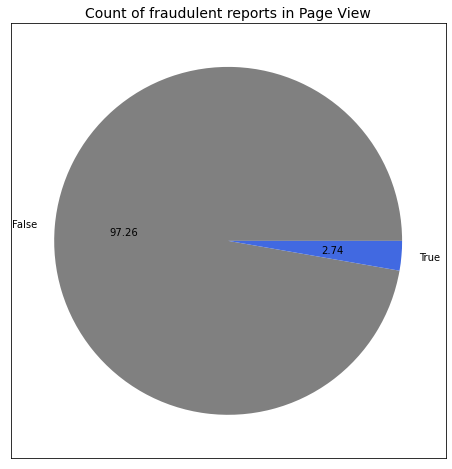

False    4821
True      136
Name: AVG_BYTES_PER_REPORT, dtype: int64

In [42]:
# Making a plot
plt.figure(figsize=(8,8))
plt.pie(fraudulent_reports_page_view.value_counts(), autopct="%.2f", labels=fraudulent_reports_page_view.unique(), colors=["grey", "royalblue"])
plt.title('Count of fraudulent reports in Page View', fontsize=14)
plt.box(on=None)
plt.show()
fraudulent_reports_page_view.value_counts()

reports:reportBase    4957
Name: PAGE_CONTEXT, dtype: int64

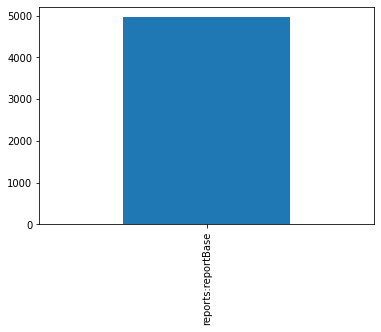

In [67]:
valid_page_view_reports.PAGE_CONTEXT.value_counts().plot(kind='bar')
valid_page_view_reports.PAGE_CONTEXT.value_counts()